In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import joblib
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ===============================
# 1. LOAD PREPROCESSED DATA
# ===============================

In [24]:
# Load preprocessed features and target
X_scaled = pd.read_csv('../Data/X_pca_transformed.csv')
y = pd.read_csv('../Data/y_target.csv').squeeze()
    
print(f"✅ Loaded preprocessed features: {X_scaled.shape}")
print(f"✅ Loaded target variable: {y.shape}")
print(f"✅ Feature names: {list(X_scaled.columns)}")
print(f"✅ Target distribution: {y.value_counts().to_dict()}")

✅ Loaded preprocessed features: (303, 10)
✅ Loaded target variable: (303,)
✅ Feature names: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
✅ Target distribution: {0: 164, 1: 139}


# ===============================
# 2. UNIVARIATE FEATURE SELECTION
# ===============================

In [25]:
# Method 1: Chi-Square Test (requires non-negative values)
print("🔹 Method 1: Chi-Square Test")

# Shift features to be non-negative (if needed)
X_chi2_ready = X_scaled.copy()
min_vals = X_chi2_ready.min()
if (min_vals < 0).any():
    X_chi2_ready += np.abs(min_vals.min()) + 1e-5  # shift all to positive

chi2_selector = SelectKBest(score_func=chi2, k='all')
X_chi2_scores = chi2_selector.fit_transform(X_chi2_ready, y)
chi2_scores = chi2_selector.scores_
chi2_pvalues = chi2_selector.pvalues_


# Method 2: Mutual Information
print("🔹 Method 2: Mutual Information")
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
X_mi_scores = mi_selector.fit_transform(X_scaled, y)
mi_scores = mi_selector.scores_

# Create univariate results DataFrame
univariate_results = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Chi2_Score': chi2_scores,
    'Chi2_PValue': chi2_pvalues,
    'MI_Score': mi_scores
})

# Sort by Chi2 score
univariate_results = univariate_results.sort_values('Chi2_Score', ascending=False)
print(f" Computed univariate statistics for {len(univariate_results)} features")

# Display top features
print(f"\n Top 10 Features by Chi-Square Score:")
print(univariate_results.head(10)[['Feature', 'Chi2_Score', 'Chi2_PValue']].round(4))

print(f"\n Top 10 Features by Mutual Information:")
mi_sorted = univariate_results.sort_values('MI_Score', ascending=False)
print(mi_sorted.head(10)[['Feature', 'MI_Score']].round(4))

🔹 Method 1: Chi-Square Test
🔹 Method 2: Mutual Information
 Computed univariate statistics for 10 features

 Top 10 Features by Chi-Square Score:
  Feature  Chi2_Score  Chi2_PValue
0     PC1    105.0108       0.0000
1     PC2      2.4122       0.1204
3     PC4      2.1831       0.1395
8     PC9      0.3847       0.5351
4     PC5      0.3565       0.5505
5     PC6      0.3048       0.5809
6     PC7      0.1830       0.6688
2     PC3      0.0375       0.8465
7     PC8      0.0083       0.9272
9    PC10      0.0061       0.9378

 Top 10 Features by Mutual Information:
  Feature  MI_Score
0     PC1    0.2946
3     PC4    0.0586
2     PC3    0.0511
8     PC9    0.0409
5     PC6    0.0237
9    PC10    0.0076
4     PC5    0.0069
1     PC2    0.0000
6     PC7    0.0000
7     PC8    0.0000


# ===============================
# 3. TREE-BASED FEATURE IMPORTANCE
# ===============================

In [26]:
# Random Forest Feature Importance
print("🔹 Random Forest Feature Importance")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_scaled, y)
rf_importance = rf_selector.feature_importances_

# Create feature importance DataFrame
rf_importance_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'RF_Importance': rf_importance
}).sort_values('RF_Importance', ascending=False)

print(f" Computed Random Forest importance for {len(rf_importance_df)} features")
print(f"\n Top 10 Features by Random Forest Importance:")
print(rf_importance_df.head(10).round(4))

🔹 Random Forest Feature Importance
 Computed Random Forest importance for 10 features

 Top 10 Features by Random Forest Importance:
  Feature  RF_Importance
0     PC1         0.4368
3     PC4         0.0807
5     PC6         0.0767
8     PC9         0.0635
1     PC2         0.0632
7     PC8         0.0584
2     PC3         0.0574
9    PC10         0.0553
4     PC5         0.0541
6     PC7         0.0540


# ===============================
# 4. RECURSIVE FEATURE ELIMINATION
# ===============================

In [27]:
# Define different numbers of features to select
n_features_options = [5, 6, 7, 8, 9, 10]
rfe_results = {}

for n_features in n_features_options:
    print(f"🔹 RFE with {n_features} features")
    
    # RFE with Logistic Regression
    rfe_lr = RFE(estimator=LogisticRegression(random_state=42, max_iter=1000), 
                 n_features_to_select=n_features)
    rfe_lr.fit(X_scaled, y)
    
    # RFE with Random Forest
    rfe_rf = RFE(estimator=RandomForestClassifier(n_estimators=50, random_state=42), 
                 n_features_to_select=n_features)
    rfe_rf.fit(X_scaled, y)
    
    # Store results
    rfe_results[n_features] = {
        'lr_features': X_scaled.columns[rfe_lr.support_].tolist(),
        'rf_features': X_scaled.columns[rfe_rf.support_].tolist(),
        'lr_ranking': rfe_lr.ranking_,
        'rf_ranking': rfe_rf.ranking_
    }
    
    print(f"    LR selected: {rfe_results[n_features]['lr_features']}")
    print(f"    RF selected: {rfe_results[n_features]['rf_features']}")

🔹 RFE with 5 features
    LR selected: ['PC1', 'PC2', 'PC4', 'PC6', 'PC9']
    RF selected: ['PC1', 'PC2', 'PC4', 'PC6', 'PC9']
🔹 RFE with 6 features
    LR selected: ['PC1', 'PC2', 'PC4', 'PC5', 'PC6', 'PC9']
    RF selected: ['PC1', 'PC2', 'PC4', 'PC6', 'PC9', 'PC10']
🔹 RFE with 7 features
    LR selected: ['PC1', 'PC2', 'PC4', 'PC5', 'PC6', 'PC7', 'PC9']
    RF selected: ['PC1', 'PC2', 'PC4', 'PC6', 'PC8', 'PC9', 'PC10']
🔹 RFE with 8 features
    LR selected: ['PC1', 'PC2', 'PC4', 'PC5', 'PC6', 'PC7', 'PC9', 'PC10']
    RF selected: ['PC1', 'PC2', 'PC3', 'PC4', 'PC6', 'PC8', 'PC9', 'PC10']
🔹 RFE with 9 features
    LR selected: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC9', 'PC10']
    RF selected: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC8', 'PC9', 'PC10']
🔹 RFE with 10 features
    LR selected: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
    RF selected: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']


# ===============================
# 5. FEATURE SELECTION VISUALIZATION
# ===============================

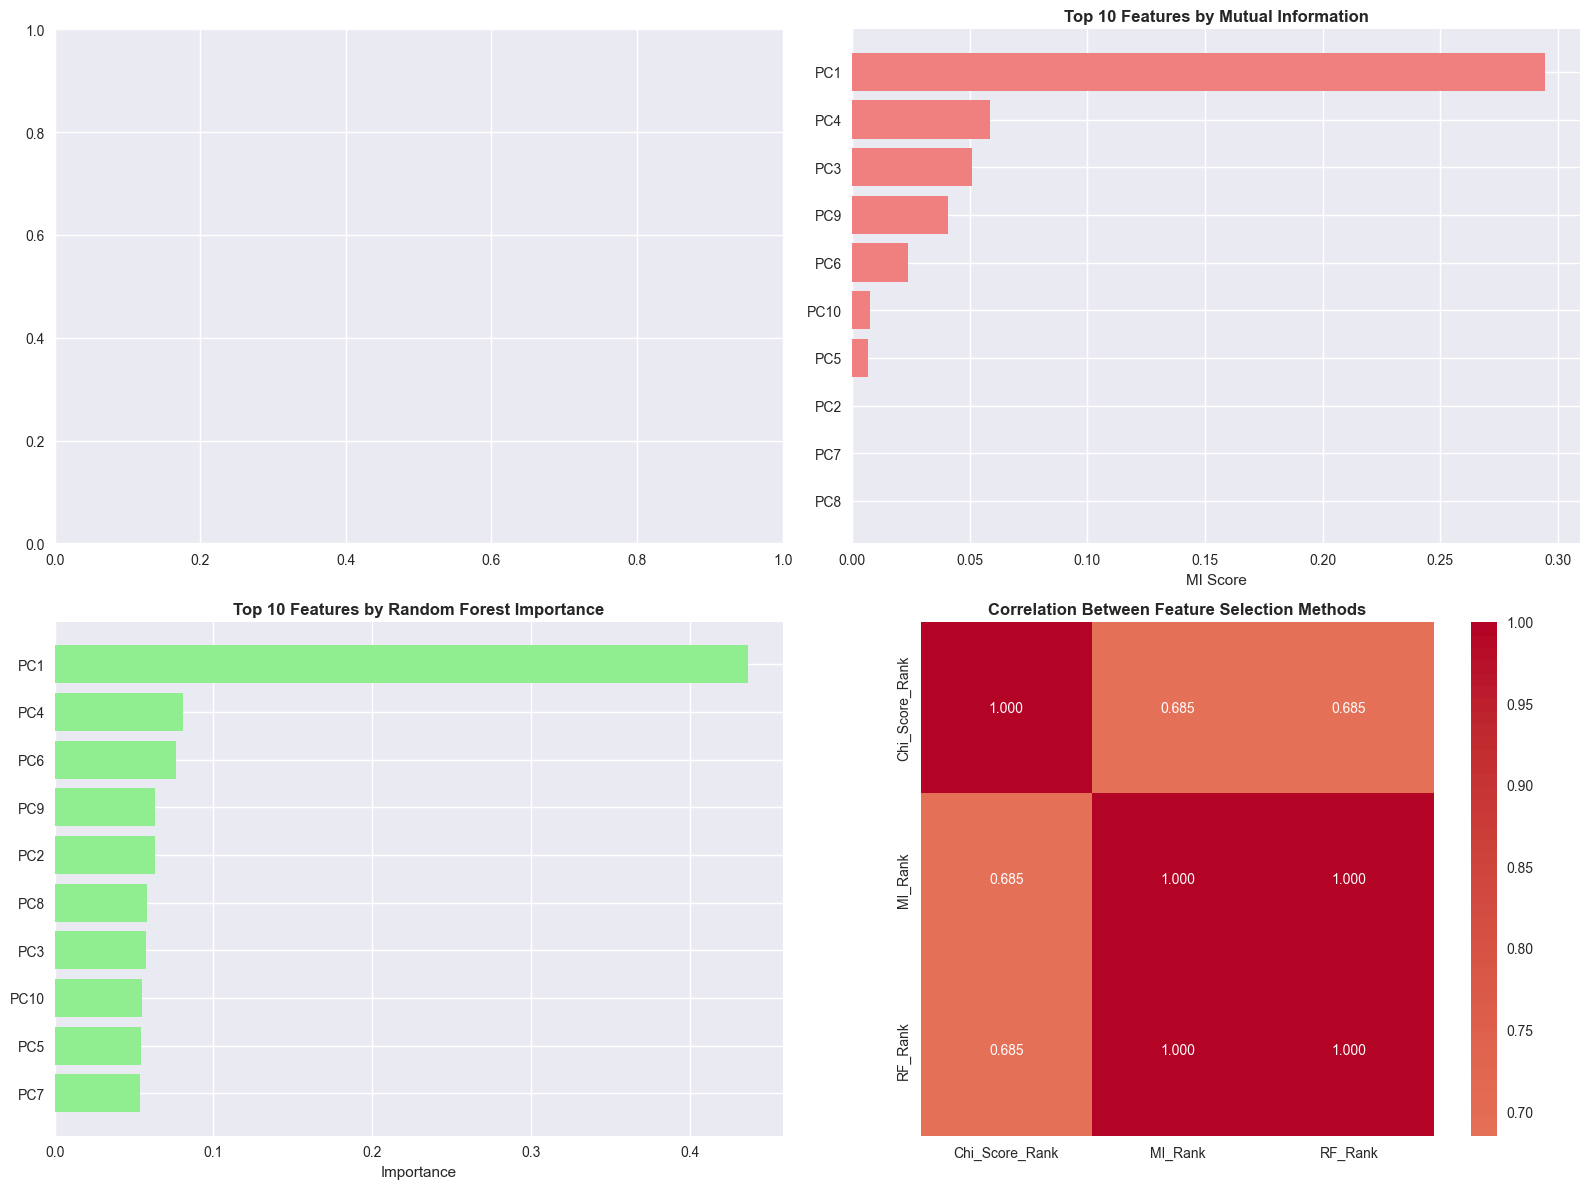

In [28]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# # 1. Chi-Score ranking
# top_f_features = univariate_results.head(10)
# axes[0,0].barh(range(len(top_Chi_features)), top_Chi_features['Chi2_Score'], color='skyblue')
# axes[0,0].set_yticks(range(len(top_Chi_features)))
# axes[0,0].set_yticklabels(top_Chi_features['Feature'])
# axes[0,0].set_title('Top 10 Features by Chi-Square Score', fontweight='bold')
# axes[0,0].set_xlabel('Chi2 Score')
# axes[0,0].invert_yaxis()

# 2. Mutual Information ranking
top_mi_features = mi_sorted.head(10)
axes[0,1].barh(range(len(top_mi_features)), top_mi_features['MI_Score'], color='lightcoral')
axes[0,1].set_yticks(range(len(top_mi_features)))
axes[0,1].set_yticklabels(top_mi_features['Feature'])
axes[0,1].set_title('Top 10 Features by Mutual Information', fontweight='bold')
axes[0,1].set_xlabel('MI Score')
axes[0,1].invert_yaxis()

# 3. Random Forest Importance
top_rf_features = rf_importance_df.head(10)
axes[1,0].barh(range(len(top_rf_features)), top_rf_features['RF_Importance'], color='lightgreen')
axes[1,0].set_yticks(range(len(top_rf_features)))
axes[1,0].set_yticklabels(top_rf_features['Feature'])
axes[1,0].set_title('Top 10 Features by Random Forest Importance', fontweight='bold')
axes[1,0].set_xlabel('Importance')
axes[1,0].invert_yaxis()

# 4. Feature selection methods comparison (correlation heatmap)
# Create correlation matrix of different ranking methods
ranking_comparison = pd.DataFrame({
    'Chi_Score_Rank': univariate_results.reset_index(drop=True).index + 1,
    'MI_Rank': mi_sorted.reset_index().set_index('Feature').loc[univariate_results['Feature']]['index'] + 1,
    'RF_Rank': rf_importance_df.reset_index().set_index('Feature').loc[univariate_results['Feature']]['index'] + 1
}, index=univariate_results['Feature'])

# Calculate correlation between ranking methods
ranking_corr = ranking_comparison.corr()
sns.heatmap(ranking_corr, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', ax=axes[1,1])
axes[1,1].set_title('Correlation Between Feature Selection Methods', fontweight='bold')

plt.tight_layout()
plt.show()

In [29]:
# Define top K features for consensus
k_best = 10
print(f" Selecting top {k_best} features using consensus approach")

# Get top features from each method
top_Chi_features_list = univariate_results.head(k_best)['Feature'].tolist()
top_mi_features_list = mi_sorted.head(k_best)['Feature'].tolist()
top_rf_features_list = rf_importance_df.head(k_best)['Feature'].tolist()
top_rfe_lr_features = rfe_results[k_best]['lr_features']
top_rfe_rf_features = rfe_results[k_best]['rf_features']

# Create voting system
all_methods_features = {
    'Chi_Score': top_Chi_features_list,
    'MI_Score': top_mi_features_list,
    'RF_Importance': top_rf_features_list,
    'RFE_LR': top_rfe_lr_features,
    'RFE_RF': top_rfe_rf_features
}

# Count votes for each feature
feature_votes = {}
for method, features in all_methods_features.items():
    for feature in features:
        feature_votes[feature] = feature_votes.get(feature, 0) + 1

# Sort features by votes
consensus_features = sorted(feature_votes.items(), key=lambda x: x[1], reverse=True)

print(f"\n📊 Feature Voting Results:")
print("Feature Name | Votes | Methods")
print("-" * 50)
for feature, votes in consensus_features:
    methods = [method for method, features in all_methods_features.items() if feature in features]
    print(f"{feature:<20} | {votes}/5  | {', '.join(methods)}")

# Select final features (top voted features)
final_features = [feature for feature, votes in consensus_features if votes >= 3][:k_best]
print(f"\n✅ Final selected features ({len(final_features)}): {final_features}")


 Selecting top 10 features using consensus approach

📊 Feature Voting Results:
Feature Name | Votes | Methods
--------------------------------------------------
PC1                  | 5/5  | Chi_Score, MI_Score, RF_Importance, RFE_LR, RFE_RF
PC2                  | 5/5  | Chi_Score, MI_Score, RF_Importance, RFE_LR, RFE_RF
PC4                  | 5/5  | Chi_Score, MI_Score, RF_Importance, RFE_LR, RFE_RF
PC9                  | 5/5  | Chi_Score, MI_Score, RF_Importance, RFE_LR, RFE_RF
PC5                  | 5/5  | Chi_Score, MI_Score, RF_Importance, RFE_LR, RFE_RF
PC6                  | 5/5  | Chi_Score, MI_Score, RF_Importance, RFE_LR, RFE_RF
PC7                  | 5/5  | Chi_Score, MI_Score, RF_Importance, RFE_LR, RFE_RF
PC3                  | 5/5  | Chi_Score, MI_Score, RF_Importance, RFE_LR, RFE_RF
PC8                  | 5/5  | Chi_Score, MI_Score, RF_Importance, RFE_LR, RFE_RF
PC10                 | 5/5  | Chi_Score, MI_Score, RF_Importance, RFE_LR, RFE_RF

✅ Final selected features (1

# ===============================
# 7. EVALUATE FEATURE SUBSETS
# ===============================

In [30]:
# Define feature subsets to evaluate
feature_subsets = {
    'All_Features': list(X_scaled.columns),
    'Top_CHi_Score': top_Chi_features_list,
    'Top_MI': top_mi_features_list,
    'Top_RF': top_rf_features_list,
    'RFE_LR': top_rfe_lr_features,
    'RFE_RF': top_rfe_rf_features,
    'Consensus': final_features
}

# Evaluate each subset using cross-validation
evaluation_results = []

print(" Evaluating feature subsets...")
for subset_name, features in feature_subsets.items():
    X_subset = X_scaled[features]
    
    # Logistic Regression evaluation
    lr_scores = cross_val_score(LogisticRegression(random_state=42, max_iter=1000), 
                               X_subset, y, cv=5, scoring='accuracy')
    
    # Random Forest evaluation
    rf_scores = cross_val_score(RandomForestClassifier(n_estimators=50, random_state=42), 
                               X_subset, y, cv=5, scoring='accuracy')
    
    evaluation_results.append({
        'Subset': subset_name,
        'N_Features': len(features),
        'LR_CV_Mean': lr_scores.mean(),
        'LR_CV_Std': lr_scores.std(),
        'RF_CV_Mean': rf_scores.mean(),
        'RF_CV_Std': rf_scores.std(),
        'Features': features
    })
    
    print(f"   {subset_name}: {len(features)} features, LR: {lr_scores.mean():.4f}±{lr_scores.std():.4f}, RF: {rf_scores.mean():.4f}±{rf_scores.std():.4f}")

# Convert to DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_results)
print(f"\n Feature Subset Evaluation Results:")
print(evaluation_df[['Subset', 'N_Features', 'LR_CV_Mean', 'RF_CV_Mean']].round(4))


 Evaluating feature subsets...
   All_Features: 10 features, LR: 0.8316±0.0321, RF: 0.8149±0.0556
   Top_CHi_Score: 10 features, LR: 0.8316±0.0321, RF: 0.8019±0.0385
   Top_MI: 10 features, LR: 0.8316±0.0321, RF: 0.8085±0.0345
   Top_RF: 10 features, LR: 0.8316±0.0321, RF: 0.8184±0.0459
   RFE_LR: 10 features, LR: 0.8316±0.0321, RF: 0.8149±0.0556
   RFE_RF: 10 features, LR: 0.8316±0.0321, RF: 0.8149±0.0556
   Consensus: 10 features, LR: 0.8316±0.0321, RF: 0.8019±0.0385

 Feature Subset Evaluation Results:
          Subset  N_Features  LR_CV_Mean  RF_CV_Mean
0   All_Features          10      0.8316      0.8149
1  Top_CHi_Score          10      0.8316      0.8019
2         Top_MI          10      0.8316      0.8085
3         Top_RF          10      0.8316      0.8184
4         RFE_LR          10      0.8316      0.8149
5         RFE_RF          10      0.8316      0.8149
6      Consensus          10      0.8316      0.8019


# ===============================
# 8. FINAL FEATURE SELECTION
# ===============================

In [31]:
# Select best performing feature subset
best_lr_subset = evaluation_df.loc[evaluation_df['LR_CV_Mean'].idxmax()]
best_rf_subset = evaluation_df.loc[evaluation_df['RF_CV_Mean'].idxmax()]

print(f" Best subset for Logistic Regression: {best_lr_subset['Subset']} ({best_lr_subset['LR_CV_Mean']:.4f})")
print(f" Best subset for Random Forest: {best_rf_subset['Subset']} ({best_rf_subset['RF_CV_Mean']:.4f})")

# Choose consensus features as final selection
final_selected_features = final_features
print(f"\n Final selected features for modeling: {final_selected_features}")
print(f" Number of selected features: {len(final_selected_features)}")
print(f" Reduction: {len(X_scaled.columns)} → {len(final_selected_features)} ({(1-len(final_selected_features)/len(X_scaled.columns))*100:.1f}% reduction)")

# Create final feature subset
X_selected = X_scaled[final_selected_features]
print(f" Created final feature subset: {X_selected.shape}")

 Best subset for Logistic Regression: All_Features (0.8316)
 Best subset for Random Forest: Top_RF (0.8184)

 Final selected features for modeling: ['PC1', 'PC2', 'PC4', 'PC9', 'PC5', 'PC6', 'PC7', 'PC3', 'PC8', 'PC10']
 Number of selected features: 10
 Reduction: 10 → 10 (0.0% reduction)
 Created final feature subset: (303, 10)


# ===============================
# 9. SAVE FEATURE SELECTION RESULTS
# ===============================

 Saved selected features to '../Data/X_selected_features.csv'
✅ Saved feature selection summary to 'results/'


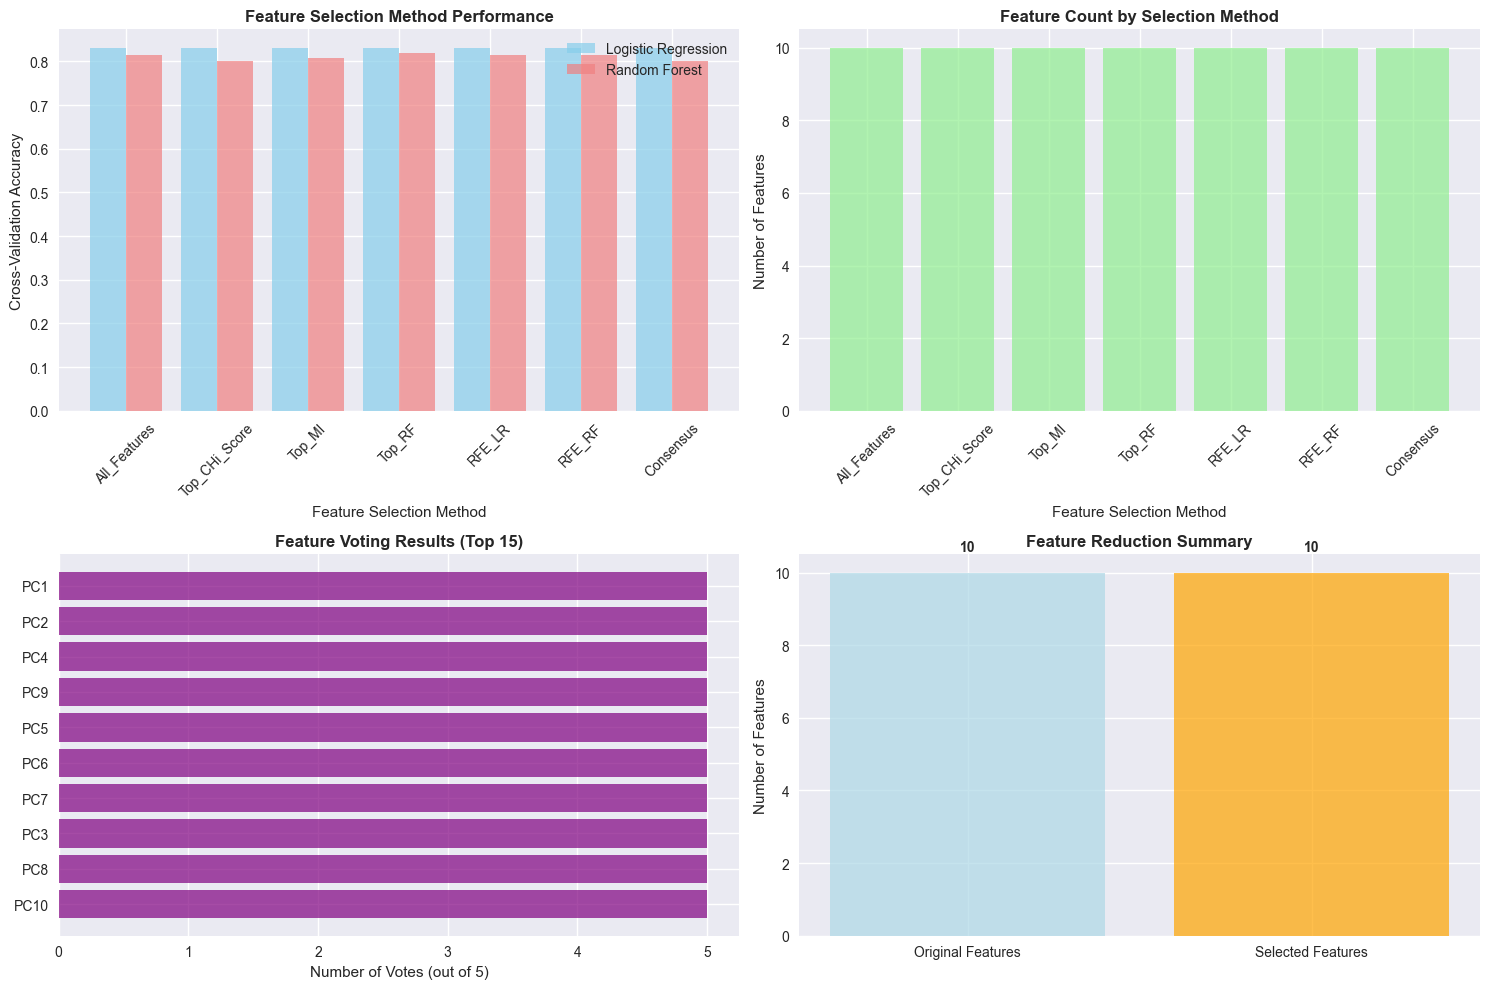

In [32]:
import os
import json

# Save selected features dataset
X_selected.to_csv('../Data/X_selected_features.csv', index=False)
print(f" Saved selected features to '../Data/X_selected_features.csv'")

# Save all feature selection results
feature_selection_results = {
    'final_selected_features': final_selected_features,
    'n_original_features': len(X_scaled.columns),
    'n_selected_features': len(final_selected_features),
    'reduction_percentage': (1-len(final_selected_features)/len(X_scaled.columns))*100,
    'univariate_results': univariate_results.to_dict('records'),
    'rf_importance': rf_importance_df.to_dict('records'),
    'rfe_results': rfe_results,
    'evaluation_results': evaluation_df.to_dict('records'),
    'feature_votes': feature_votes,
    'consensus_threshold': 3
}

# # Save as JSON
# with open('../Results/feature_selection_results.json', 'w') as f:
#     json.dump(feature_selection_results, f, indent=4)

# Save as text summary
with open('../Results/feature_selection_summary.txt', 'w') as f:
    f.write("HEART DISEASE DATASET - FEATURE SELECTION SUMMARY\n")
    f.write("=" * 55 + "\n")
    f.write(f"Original number of features: {len(X_scaled.columns)}\n")
    f.write(f"Selected number of features: {len(final_selected_features)}\n")
    f.write(f"Reduction: {(1-len(final_selected_features)/len(X_scaled.columns))*100:.1f}%\n\n")
    
    f.write("Final Selected Features:\n")
    for i, feature in enumerate(final_selected_features, 1):
        votes = feature_votes.get(feature, 0)
        f.write(f"  {i}. {feature} (votes: {votes}/5)\n")
    
    f.write(f"\nFeature Selection Method Performance:\n")
    for _, row in evaluation_df.iterrows():
        f.write(f"  {row['Subset']}: {row['N_Features']} features, ")
        f.write(f"LR: {row['LR_CV_Mean']:.4f}±{row['LR_CV_Std']:.4f}, ")
        f.write(f"RF: {row['RF_CV_Mean']:.4f}±{row['RF_CV_Std']:.4f}\n")

print(f"✅ Saved feature selection summary to 'results/'")

# Visualize final results
plt.figure(figsize=(15, 10))

# Feature selection method performance comparison
plt.subplot(2, 2, 1)
x_pos = range(len(evaluation_df))
plt.bar([x - 0.2 for x in x_pos], evaluation_df['LR_CV_Mean'], 
        width=0.4, label='Logistic Regression', alpha=0.7, color='skyblue')
plt.bar([x + 0.2 for x in x_pos], evaluation_df['RF_CV_Mean'], 
        width=0.4, label='Random Forest', alpha=0.7, color='lightcoral')
plt.xlabel('Feature Selection Method')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Feature Selection Method Performance', fontweight='bold')
plt.xticks(x_pos, evaluation_df['Subset'], rotation=45)
plt.legend()

# Number of features comparison
plt.subplot(2, 2, 2)
plt.bar(evaluation_df['Subset'], evaluation_df['N_Features'], alpha=0.7, color='lightgreen')
plt.xlabel('Feature Selection Method')
plt.ylabel('Number of Features')
plt.title('Feature Count by Selection Method', fontweight='bold')
plt.xticks(rotation=45)

# Feature voting results (top features)
plt.subplot(2, 2, 3)
top_voted_features = consensus_features[:15]
feature_names = [f[0] for f in top_voted_features]
vote_counts = [f[1] for f in top_voted_features]
plt.barh(range(len(feature_names)), vote_counts, color='purple', alpha=0.7)
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Number of Votes (out of 5)')
plt.title('Feature Voting Results (Top 15)', fontweight='bold')
plt.gca().invert_yaxis()

# Selected vs Original features
plt.subplot(2, 2, 4)
categories = ['Original Features', 'Selected Features']
counts = [len(X_scaled.columns), len(final_selected_features)]
colors = ['lightblue', 'orange']
bars = plt.bar(categories, counts, color=colors, alpha=0.7)
plt.ylabel('Number of Features')
plt.title('Feature Reduction Summary', fontweight='bold')
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()